<a href="https://colab.research.google.com/github/alibgil/sales_predictions/blob/main/Sales_predictions_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de ventas**

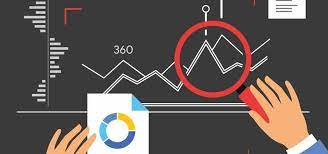

Predicción de ventas para productos alimenticios vendidos en diversas tiendas.  El objetivo de esto es ayudar al minorista a comprender las propiedades de los productos y los puntos de venta que desempeñan un papel crucial en el aumento de las ventas.

| Nombre de la variable     | Descripción                                                                                                           |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Item_Identifier           | Identificación única del producto                                                                                     |
| Item_Weight               | Peso del producto                                                                                                     |
| Item_Fat_Content          | Si el producto es bajo en grasa o regular                                                                             |
| Item_Visibility           | El porcentaje de la superficie total de exposición de todos los productos de una tienda asignada al producto concreto |
| Item_Type                 | La categoría a la que el producto pertenece                                                                           |
| Item_MRP                  | Precio máximo de venta al público (precio de catálogo) del producto                                                   |
| Outlet_Identifier         | Identificación única de la tienda                                                                                     |
| Outlet_Establishment_Year | El año cuando se estableció la tienda                                                                                 |
| Outlet_Size               | El tamaño de la tienda con respecto a la superficie                                                                   |
| Outlet_Location_Type      | El tipo de área donde está ubicada la tienda                                                                          |
| Outlet_Type               | Si el marcado es un almacén o algún tipo de supermercado                                                              |
| Item_Outlet_Sales         | Ventas del producto en la tienda particular Es la variable objetivo a predecir                                        |

In [1]:
#Librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [2]:
#Base de datos
from google.colab import drive
drive.mount('/content/drive')

filename= '/content/drive/MyDrive/BootCamp/sales_predictions.csv'

df = pd.read_csv(filename)
df.head()

Mounted at /content/drive


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

**Minería de Datos**

In [3]:
#inspect the data
print(df.info(), '\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

Item_Identifier                 0
Item

Podemos ver una mezcla de tipos de datos con datos faltantes en columnas flotantes y columnas de objetos.

In [4]:
#Identificación categorías
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object'] ]
for cat in cat_var:
  print(df[cat].value_counts())

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
Medium    279

Se procede a homologar las categorías de la variable Item_Fat_Content

In [5]:
df.replace({"LF": 'Low Fat', "low fat": 'Low Fat', "reg": 'Regular'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [6]:
# División de valores
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Instanciar selectores
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [8]:
# Instanciar transformadores
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [9]:
# Instanciar pipelines
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [10]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [11]:
#Instanciar transformador de columnas

# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22c53ba6a0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22c53baeb0>)])

In [12]:
#Transformar datos

# fit on train
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [13]:
# Comprobación de los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1592)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

Finalmente evidenciamos que nuestros datos estan completos, sin faltantes